In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from pprint import pprint
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, freqz

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection import metrics
from sleeprnn.helpers import reader, plotter, printer, misc, performer

RESULTS_PATH = os.path.join(project_root, 'results')

%matplotlib inline
viz.notebook_full_width()

# Functions

In [2]:
def analyze_spindle(spindle, fs):
    duration = spindle.size / fs
    pp_amplitude = spindle.max() - spindle.min()
    rms = np.sqrt(np.mean(spindle ** 2))
    central_freq_count = find_peaks(spindle)[0].size / duration
    # Compute peak frequency by fft
    w, h = freqz(spindle)
    resp_freq = w * fs / (2*np.pi)
    resp_amp = abs(h)
    max_loc = np.argmax(resp_amp)
    central_freq_fft = resp_freq[max_loc]
    results = {
        'duration': duration,
        'pp_amplitude': pp_amplitude,
        'rms': rms,
        'central_freq_count': central_freq_count,
        'central_freq_fft': central_freq_fft
    }
    return results


def get_band_weights(freq_vals, lim_low, lim_high):
    band_low = (freq_vals >= lim_low).astype(np.float32)
    band_high = (freq_vals <= lim_high).astype(np.float32)
    band_weights = band_low * band_high
    return band_weights

        
def get_band_power(power_vals, freq_vals, lim_low, lim_high, mode):
    if mode not in ["mean", "max"]:
        raise ValueError()
    w = get_band_weights(freq_vals, lim_low, lim_high)
    weighted_power = w * power_vals
    if mode == "mean":
        band_power = np.sum(weighted_power) / np.sum(w)
    else:
        band_power =  np.max(weighted_power)
    return band_power


def analyze_spindle_window(signal_window, fs):
    window_han = np.hanning(signal_window.size)
    signal_window = signal_window * window_han
    padding = np.zeros(1 * fs)
    signal_window_extended = np.concatenate([padding, signal_window, padding])
    amp, freqs = utils.power_spectrum(signal_window_extended, fs)
    
    # Kulkarni (SpindleNet) power ratio
    num_power = get_band_power(amp, freqs, 9, 16, mode="mean")
    den_power = get_band_power(amp, freqs, 2, 8, mode="mean")
    pr_spindlenet = num_power / (den_power + 1e-6) 

    # Lacourse (A7) power ratio
    num_power = get_band_power(amp, freqs, 11, 16, mode="mean")
    den_power = get_band_power(amp, freqs, 4.5, 30, mode="mean")
    pr_a7 = num_power / (den_power + 1e-6)

    # Huupponen (sigma index) power ratio
    num_power = get_band_power(amp, freqs, 10.5, 16, mode="max")
    den_power_1 = get_band_power(amp, freqs, 4, 10, mode="mean")
    den_power_2 = get_band_power(amp, freqs, 20, 40, mode="mean")
    alpha_power = get_band_power(amp, freqs, 7.5, 10, mode="max")
    pr_huupp = 2.0 * num_power / (den_power_1 + den_power_2 + 1e-6)
    pr_huupp_alfa = num_power / (alpha_power + 1e-6)
    
    results = {
        'pr_spindlenet': pr_spindlenet,
        'pr_a7': pr_a7,
        'pr_huupp': pr_huupp,
        'pr_huupp_alfa': pr_huupp_alfa,
    }
    return results


def analyze_spindle_window_custom(signal_window, fs, bands_list):
    window_han = np.hanning(signal_window.size)
    signal_window = signal_window * window_han
    padding = np.zeros(1 * fs)
    signal_window_extended = np.concatenate([padding, signal_window, padding])
    amp, freqs = utils.power_spectrum(signal_window_extended, fs)
    sigma_power = get_band_power(amp, freqs, 11, 16, mode="mean")
    power_list = []
    for band in bands_list:
        band_power = get_band_power(amp, freqs, band[0], band[1], mode="mean")
        power_list.append(sigma_power / band_power)
    results = {'band_%d' % i: power_list[i] for i in range(len(bands_list))}
    return results

def analyze_spindle_window_spectrum(signal_window, fs):
    window_han = np.hanning(signal_window.size)
    signal_window = signal_window * window_han
    padding = np.zeros(1 * fs)
    signal_window_extended = np.concatenate([padding, signal_window, padding])
    amp, freqs = utils.power_spectrum(signal_window_extended, fs)
    sigma_power = get_band_power(amp, freqs, 11, 16, mode="max")
    sigma_norm_amp = amp / sigma_power
    results = {
        'spectrum': np.stack([freqs, amp], axis=1), 
        'spectrum_sigma_norm': np.stack([freqs, sigma_norm_amp], axis=1)}
    return results


def listify_dictionaries(list_of_dicts):
    dict_of_lists = {}
    for key in list_of_dicts[0].keys():
        dict_of_lists[key] = []
        for single_dict in list_of_dicts:
            dict_of_lists[key].append(single_dict[key])
    return dict_of_lists


def fft_based_scaling(signal, fs, pages, page_size, band=None):
    # Using FFT on whole page
    amp_all = []
    freq_all = []
    window_han = np.hanning(page_size)
    for page in pages:
        start_page = page * page_size
        end_page = start_page + page_size
        amp, freq = utils.power_spectrum(window_han * signal[start_page:end_page], fs)
        amp_all.append(amp)
        freq_all.append(freq)
    amp_all = np.stack(amp_all, axis=0).mean(axis=0)
    freq_all = np.stack(freq_all, axis=0).mean(axis=0)
    if band is None:
        scaling_factor = 1 / np.mean(amp_all)
    else:
        first_freq_loc = np.argmin((freq_all - band[0]) ** 2)
        last_freq_loc = np.argmin((freq_all - band[1]) ** 2)
        scaling_factor = 1 / np.mean(amp_all[first_freq_loc:(last_freq_loc+1)])
    return scaling_factor


def raw_spectrum(signal, fs, pages, page_size):
    # Using FFT on whole page
    amp_all = []
    freq_all = []
    window_han = np.hanning(page_size)
    for page in pages:
        start_page = page * page_size
        end_page = start_page + page_size
        amp, freq = utils.power_spectrum(window_han * signal[start_page:end_page], fs)
        amp_all.append(amp)
        freq_all.append(freq)
    amp_all = np.stack(amp_all, axis=0).mean(axis=0)
    freq_all = np.stack(freq_all, axis=0).mean(axis=0)
    spectrum_page = np.stack([freq_all, amp_all], axis=1)
    
    # Using FFT on 2-seconds segments
    amp_all = []
    freq_all = []
    window_size = 2 * fs
    window_han = np.hanning(window_size)
    n_windows = int(2 * (page_size / window_size) - 1)
    for page in pages:
        start_page = page * page_size
        end_page = start_page + page_size
        segment_signal = signal[start_page:end_page]
        for i in range(n_windows):
            start_window = int(i * window_size / 2)
            end_window = start_window + window_size
            window_signal = segment_signal[start_window:end_window] * window_han
            padding = np.zeros(1 * fs)
            window_signal_extended = np.concatenate([padding, window_signal, padding])
            amp, freq = utils.power_spectrum(window_signal_extended, fs)
            amp_all.append(amp)
            freq_all.append(freq)
    amp_all = np.stack(amp_all, axis=0).mean(axis=0)
    freq_all = np.stack(freq_all, axis=0).mean(axis=0)
    spectrum_window = np.stack([freq_all, amp_all], axis=1)
    
    results = {
        'spectrum_page': spectrum_page,
        'spectrum_window': spectrum_window
    }
    return results


def center_probabilities(probabilities, center):
    """input: probas with class 1 iff proba > center.
    output: probas with class 1 iff proba > 0.5
    """
    bias_center = np.log(center / (1-center))
    eps = 1e-6
    probabilities = np.clip(probabilities, eps, 1-eps)
    logits = np.log(probabilities / (1 - probabilities))
    logits = logits - bias_center
    probabilities = 1 / (1 + np.exp(-logits))
    return probabilities

# Load Dataset

In [3]:
dataset_name = constants.MASS_SS_NAME
fs = 200
dataset = reader.load_dataset(dataset_name, params={pkeys.FS: fs})

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042


# RED Validation Performance (MASS-SS-E1-N2)

In [4]:
filter_dates = [20200724, None]
printer.print_available_ckpt(OPTIMAL_THR_FOR_CKPT_DICT, filter_dates)

Available ckpt:
    20200724_reproduce_red_n2_train_mass_ss/v19_rep2
    20200724_reproduce_red_n2_train_mass_ss/v19_rep4
    20200724_reproduce_red_n2_train_mass_ss/v19_rep1
    20200724_reproduce_red_n2_train_mass_ss/v19_rep3
    20200724_reproduce_red_n2_train_mass_ss/v11_rep2
    20200724_reproduce_red_n2_train_mass_ss/v11_rep3
    20200724_reproduce_red_n2_train_mass_ss/v11_rep4
    20200724_reproduce_red_n2_train_mass_ss/v11_rep1
    20200724_reproduce_red_n2_train_mass_kc/v19_rep3
    20200724_reproduce_red_n2_train_mass_kc/v19_rep2
    20200724_reproduce_red_n2_train_mass_kc/v19_rep1
    20200724_reproduce_red_n2_train_mass_kc/v19_rep4
    20200724_reproduce_red_n2_train_mass_kc/v11_rep3
    20200724_reproduce_red_n2_train_mass_kc/v11_rep2
    20200724_reproduce_red_n2_train_mass_kc/v11_rep4
    20200724_reproduce_red_n2_train_mass_kc/v11_rep1
    20200914_fft_based_norm_n2_train_mass_ss/v11_rep2
    20200914_fft_based_norm_n2_train_mass_ss/v11_rep1
    20200914_fft_based_norm_

In [5]:
# Settings
ref_ckpt_folder = '20200724_reproduce_red_n2_train_mass_ss/v19_rep1'
seed_id_list = [0, 1, 2, 3]

which_expert = 1
task_mode = constants.N2_RECORD
set_list = [constants.VAL_SUBSET, constants.TRAIN_SUBSET]
iou_thr = 0.2
iou_hist_bins = np.linspace(0, 1, 21)
iou_curve_axis = misc.custom_linspace(0.05, 0.95, 0.05)
ids_dict = {constants.ALL_TRAIN_SUBSET: dataset.train_ids, constants.TEST_SUBSET: dataset.test_ids}
ids_dict.update(misc.get_splits_dict(dataset, seed_id_list))

# Load predictions
ref_predictions_dict = reader.read_prediction_with_seeds(
    ref_ckpt_folder, dataset_name, task_mode, seed_id_list, set_list=set_list, parent_dataset=dataset)

# Compute performance by subject
ref_precision_dict = {}
ref_recall_dict = {}
for seed_id in seed_id_list:
    data_inference = FeederDataset(dataset, ids_dict[seed_id][constants.VAL_SUBSET], task_mode, which_expert)
    this_ids = data_inference.get_ids()
    this_events_list = data_inference.get_stamps()
    prediction_obj = ref_predictions_dict[seed_id][constants.VAL_SUBSET]
    prediction_obj.set_probability_threshold(OPTIMAL_THR_FOR_CKPT_DICT[ref_ckpt_folder][seed_id])
    this_detections_list = prediction_obj.get_stamps()
    for i, single_id in enumerate(this_ids):
        single_events = this_events_list[i]
        single_detections = this_detections_list[i]
        this_precision = metrics.metric_vs_iou(single_events, single_detections, [iou_thr], metric_name=constants.PRECISION)
        this_recall = metrics.metric_vs_iou(single_events, single_detections, [iou_thr], metric_name=constants.RECALL)
        ref_precision_dict[single_id] = this_precision[0]
        ref_recall_dict[single_id] = this_recall[0]
print("Done.")

Loading predictions
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed0
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed1
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed2
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed3
Done.


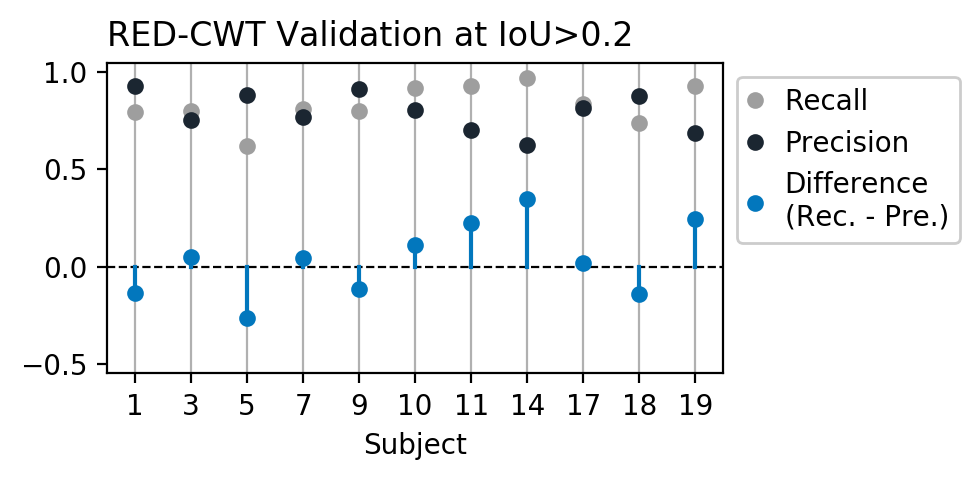

In [16]:
color_recall = viz.GREY_COLORS[5]
color_precision = viz.PALETTE['dark']
color_difference = viz.PALETTE['blue']
markersize = 5

fig, ax = plt.subplots(1, 1, figsize=(5, 2.5), dpi=200)
for i, single_id in enumerate(dataset.train_ids):
    rec_label = "Recall" if i==0 else None
    pre_label = "Precision" if i==0 else None
    diff_label = "Difference\n(Rec. - Pre.)" if i==0 else None
    difference = ref_recall_dict[single_id] - ref_precision_dict[single_id]
    ax.plot(
        i, ref_recall_dict[single_id], markersize=markersize, marker='o', 
        color=color_recall, label=rec_label, linestyle="none")
    ax.plot(
        i, ref_precision_dict[single_id], markersize=markersize, marker='o', 
        color=color_precision, label=pre_label, linestyle="none")
    ax.plot(
        i, difference, markersize=markersize, marker='o', 
        color=color_difference, label=diff_label, linestyle="none")
    ax.plot([i, i], [0, difference], color=color_difference, linewidth=1.5)
ax.axhline(0, color="k", linewidth=0.8, linestyle="--", zorder=1)
ax.set_ylim([-0.55, 1.05])
ax.set_xticks(range(len(dataset.train_ids)))
ax.set_xticklabels(dataset.train_ids)
ax.set_xlabel("Subject")
ax.legend(loc="upper left", ncol=1, handlelength=0.5, framealpha=1, bbox_to_anchor=(1, 1))
ax.grid(axis="x")
ax.set_title("RED-CWT Validation at IoU>%1.1f" % iou_thr, loc="left")
plt.tight_layout()
plt.show()

## Change in performance after FFT-based normalization

In [7]:
# Load other predictions
new_ckpt_folder = '20200914_fft_based_norm_n2_train_mass_ss/v19_rep1'
new_predictions_dict = reader.read_prediction_with_seeds(
    new_ckpt_folder, dataset_name, task_mode, seed_id_list, set_list=set_list, parent_dataset=dataset)

# Compute performance by subject
new_precision_dict = {}
new_recall_dict = {}
for seed_id in seed_id_list:
    data_inference = FeederDataset(dataset, ids_dict[seed_id][constants.VAL_SUBSET], task_mode, which_expert)
    this_ids = data_inference.get_ids()
    this_events_list = data_inference.get_stamps()
    prediction_obj = new_predictions_dict[seed_id][constants.VAL_SUBSET]
    prediction_obj.set_probability_threshold(OPTIMAL_THR_FOR_CKPT_DICT[new_ckpt_folder][seed_id])
    this_detections_list = prediction_obj.get_stamps()
    for i, single_id in enumerate(this_ids):
        single_events = this_events_list[i]
        single_detections = this_detections_list[i]
        this_precision = metrics.metric_vs_iou(single_events, single_detections, [iou_thr], metric_name=constants.PRECISION)
        this_recall = metrics.metric_vs_iou(single_events, single_detections, [iou_thr], metric_name=constants.RECALL)
        new_precision_dict[single_id] = this_precision[0]
        new_recall_dict[single_id] = this_recall[0]
print("Done.")

Loading predictions
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200914_fft_based_norm_n2_train_mass_ss/v19_rep1/seed0
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200914_fft_based_norm_n2_train_mass_ss/v19_rep1/seed1
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200914_fft_based_norm_n2_train_mass_ss/v19_rep1/seed2
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200914_fft_based_norm_n2_train_mass_ss/v19_rep1/seed3
Done.


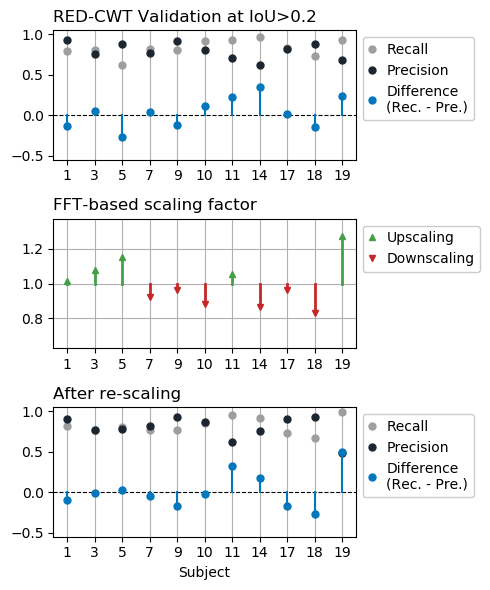

In [8]:
color_recall = viz.GREY_COLORS[5]
color_precision = viz.PALETTE['dark']
color_difference = viz.PALETTE['blue']
color_positive = viz.PALETTE['green']
color_negative = viz.PALETTE['red']
markersize = 5

fig, axes = plt.subplots(3, 1, figsize=(5, 6), dpi=100)
ax = axes[0]
for i, single_id in enumerate(dataset.train_ids):
    rec_label = "Recall" if i==0 else None
    pre_label = "Precision" if i==0 else None
    diff_label = "Difference\n(Rec. - Pre.)" if i==0 else None
    difference = ref_recall_dict[single_id] - ref_precision_dict[single_id]
    ax.plot(
        i, ref_recall_dict[single_id], markersize=markersize, marker='o', 
        color=color_recall, label=rec_label, linestyle="none")
    ax.plot(
        i, ref_precision_dict[single_id], markersize=markersize, marker='o', 
        color=color_precision, label=pre_label, linestyle="none")
    ax.plot(
        i, difference, markersize=markersize, marker='o', 
        color=color_difference, label=diff_label, linestyle="none")
    ax.plot([i, i], [0, difference], color=color_difference, linewidth=1.5)
ax.axhline(0, color="k", linewidth=0.8, linestyle="--", zorder=1)
ax.set_ylim([-0.55, 1.05])
ax.set_xticks(range(len(dataset.train_ids)))
ax.set_xticklabels(dataset.train_ids)
ax.legend(loc="upper left", ncol=1, handlelength=0.5, framealpha=1, bbox_to_anchor=(1, 1))
ax.grid(axis="x")
ax.set_title("RED-CWT Validation at IoU>%1.1f" % iou_thr, loc="left")

ax = axes[1]
subjects_scaling_dict = {}
mean_fft_scaling = 0
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    hypno = dataset.get_subject_hypnogram(subject_id)
    n2_pages = np.where(hypno=="2")[0]
    scaling_factor = fft_based_scaling(signal, fs, n2_pages, dataset.page_size)
    mean_fft_scaling += scaling_factor
    subjects_scaling_dict[subject_id] = scaling_factor
mean_fft_scaling /= len(dataset.train_ids)
factors_list = []
upscale_shown = False
downscale_shown = False
for i, single_id in enumerate(dataset.train_ids):
    factor = subjects_scaling_dict[single_id] / mean_fft_scaling
    factors_list.append(factor)
    color = color_positive if factor > 1 else color_negative
    marker = "^" if factor > 1 else "v" 
    if factor > 1 and not upscale_shown:
        scale_label = "Upscaling"
        upscale_shown = True
    elif factor < 1 and not downscale_shown:
        scale_label = "Downscaling"
        downscale_shown = True
    else:
        scale_label = None
    ax.plot(
        i, factor, markersize=markersize, marker=marker, 
        color=color, linestyle="none", label=scale_label)
    ax.plot([i, i], [1, factor], color=color, linewidth=2)
max_delta = np.max(np.abs(factors_list) - 1) + 0.1
ax.set_ylim([1 - max_delta, 1 + max_delta])
ax.set_yticks([0.8, 1.0, 1.2])
ax.set_xticks(range(len(dataset.train_ids)))
ax.set_xticklabels(dataset.train_ids)
ax.grid()
ax.legend(loc="upper left", ncol=1, handlelength=0.5, framealpha=1, bbox_to_anchor=(1, 1))
ax.set_title("FFT-based scaling factor", loc="left")

ax = axes[2]
for i, single_id in enumerate(dataset.train_ids):
    rec_label = "Recall" if i==0 else None
    pre_label = "Precision" if i==0 else None
    diff_label = "Difference\n(Rec. - Pre.)" if i==0 else None
    difference = new_recall_dict[single_id] - new_precision_dict[single_id]
    ax.plot(
        i, new_recall_dict[single_id], markersize=markersize, marker='o', 
        color=color_recall, label=rec_label, linestyle="none")
    ax.plot(
        i, new_precision_dict[single_id], markersize=markersize, marker='o', 
        color=color_precision, label=pre_label, linestyle="none")
    ax.plot(
        i, difference, markersize=markersize, marker='o', 
        color=color_difference, label=diff_label, linestyle="none")
    ax.plot([i, i], [0, difference], color=color_difference, linewidth=1.5)
ax.axhline(0, color="k", linewidth=0.8, linestyle="--", zorder=1)
ax.set_ylim([-0.55, 1.05])
ax.set_xticks(range(len(dataset.train_ids)))
ax.set_xticklabels(dataset.train_ids)
ax.set_xlabel("Subject")
ax.legend(loc="upper left", ncol=1, handlelength=0.5, framealpha=1, bbox_to_anchor=(1, 1))
ax.grid(axis="x")
ax.set_title("After re-scaling", loc="left")
plt.tight_layout()
plt.show()

## Sensitivity to broad band integral

In [10]:
bands_list = [
    [0, 100],
    [1, 30],
    [3, 30],
    [5, 30],
    [2, 4],
    [2, 6]
]

scaling_factor_dict = {}
for band in bands_list:
    band_id = "%d-%d" % (band[0], band[1])
    scaling_factor_dict[band_id] = []
    for subject_id in dataset.train_ids:
        signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
        hypno = dataset.get_subject_hypnogram(subject_id)
        n2_pages = np.where(hypno=="2")[0]
        scaling_factor = fft_based_scaling(signal, fs, n2_pages, dataset.page_size, band=band)
        scaling_factor_dict[band_id].append(scaling_factor)
    scaling_factor_dict[band_id] = np.array(scaling_factor_dict[band_id])
    scaling_factor_dict[band_id] /= np.mean(scaling_factor_dict[band_id]) 

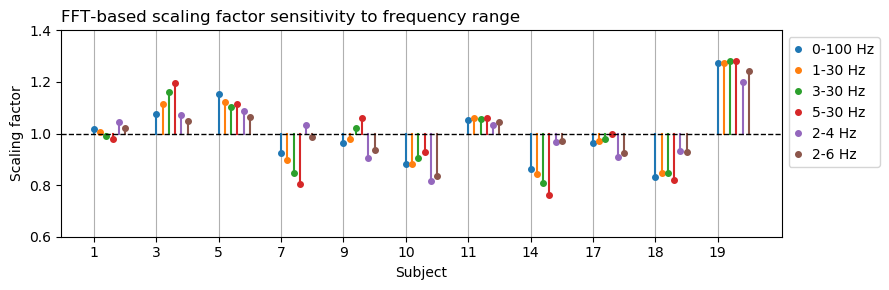

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3), dpi=100)
x_axis = np.arange(len(dataset.train_ids))
for i, band in enumerate(bands_list):
    band_id = "%d-%d" % (band[0], band[1])
    offset = i * 0.5 / (len(bands_list) - 1)
    line = ax.plot(
        x_axis + offset, scaling_factor_dict[band_id], label="%s Hz" % band_id, 
        marker='o', markersize=4, linestyle="none")
    line_color = line[0].get_color()
    for single_x, single_bar in zip(x_axis, scaling_factor_dict[band_id]):
        ax.plot([single_x + offset, single_x + offset], [1, single_bar], linewidth=1.5, color=line_color)
ax.set_xticks(x_axis)
ax.set_xticklabels(dataset.train_ids)
ax.axhline(1, color="k", linestyle="--", linewidth=1)
ax.legend(loc="upper left", bbox_to_anchor=(1, 1), handlelength=0.5)
ax.set_ylim([1 - 0.4, 1 + 0.4])
ax.set_xlabel("Subject")
ax.set_ylabel("Scaling factor")
ax.set_title("FFT-based scaling factor sensitivity to frequency range", loc="left")
ax.grid(axis="x")
plt.tight_layout()
plt.show()

# General Exploratory Analysis

## Spindle parameters

In [27]:
train_analysis = []
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    stamps = dataset.get_subject_stamps(subject_id, which_expert=1, pages_subset=constants.N2_RECORD)
    sigma_signal = utils.broad_filter(signal, fs, lowcut=9, highcut=17)
    spindles = [sigma_signal[s_start:s_end] for (s_start, s_end) in stamps]
    analysis = []
    for spindle in spindles:
        analysis_results = analyze_spindle(spindle, fs)
        analysis.append(analysis_results)
    analysis = listify_dictionaries(analysis)
    train_analysis.append(analysis)

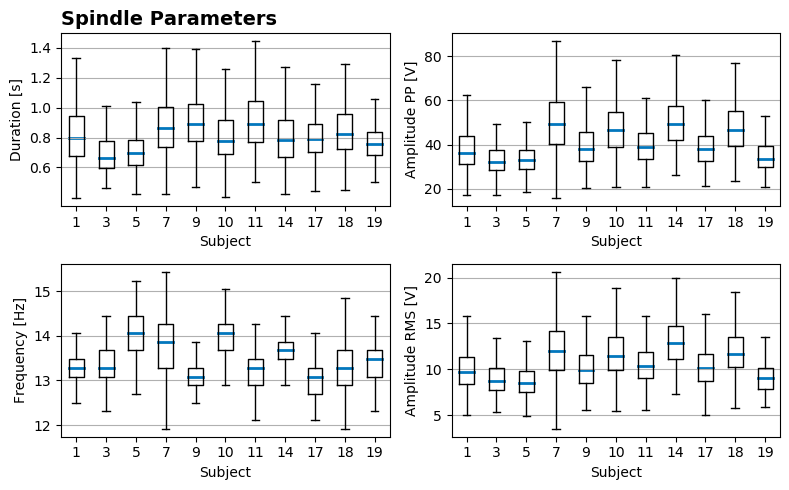

In [28]:
common_args = {
    "labels": dataset.train_ids, "showfliers": False, "flierprops": {'markersize': 2}, 
    "medianprops": dict(linewidth=2, color=viz.PALETTE['blue'], zorder=1)
}

fig, axes = plt.subplots(2, 2, figsize=(8, 5), dpi=100)
axes[0, 0].set_title("Spindle Parameters", fontweight='bold', loc="left", fontsize=14)
# Duration
ax = axes[0, 0]
ax.set_ylabel("Duration [s]")
ax.boxplot([analysis['duration'] for analysis in train_analysis], **common_args)
ax.set_yticks([0.6, 0.8, 1.0, 1.2, 1.4])
# Frequency
ax = axes[1, 0]
ax.set_ylabel("Frequency [Hz]")
ax.boxplot([analysis['central_freq_fft'] for analysis in train_analysis], **common_args)
ax.set_yticks([12, 13, 14, 15])
# Amplitude PP
ax = axes[0, 1]
ax.set_ylabel("Amplitude PP [V]")
ax.boxplot([analysis['pp_amplitude'] for analysis in train_analysis], **common_args)
ax.set_yticks([20, 40, 60, 80])
# Amplitude RMS
ax = axes[1, 1]
ax.set_ylabel("Amplitude RMS [V]")
ax.boxplot([analysis['rms'] for analysis in train_analysis], **common_args)
ax.set_yticks([5, 10, 15, 20])
for ax in axes.flatten():
    ax.grid(axis='y')
    ax.set_xlabel("Subject")
plt.tight_layout()
plt.show()

# Spectral parameters

In [32]:
band_scaling = [2, 6]
raw_train_analysis = []
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    hypno = dataset.get_subject_hypnogram(subject_id)
    n2_pages = np.where(hypno=="2")[0]
    analysis_results = raw_spectrum(signal, fs, n2_pages, dataset.page_size)    
    raw_train_analysis.append(analysis_results)
scaled_train_analysis = []
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    hypno = dataset.get_subject_hypnogram(subject_id)
    n2_pages = np.where(hypno=="2")[0]
    scaling_factor = fft_based_scaling(signal, fs, n2_pages, dataset.page_size, band=band_scaling)
    analysis_results = raw_spectrum(signal * scaling_factor, fs, n2_pages, dataset.page_size)    
    scaled_train_analysis.append(analysis_results)

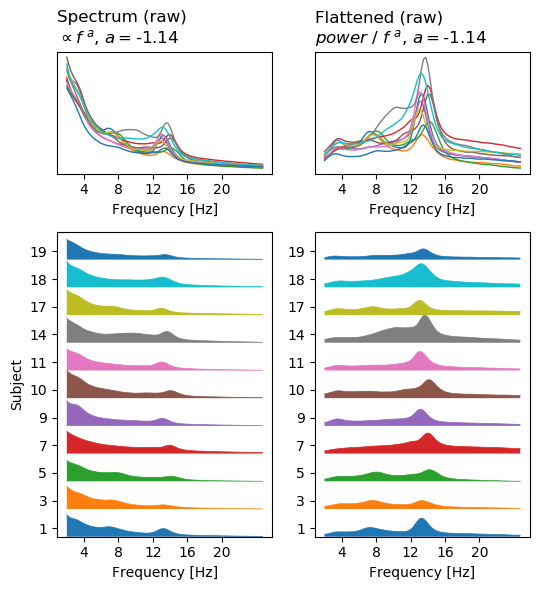

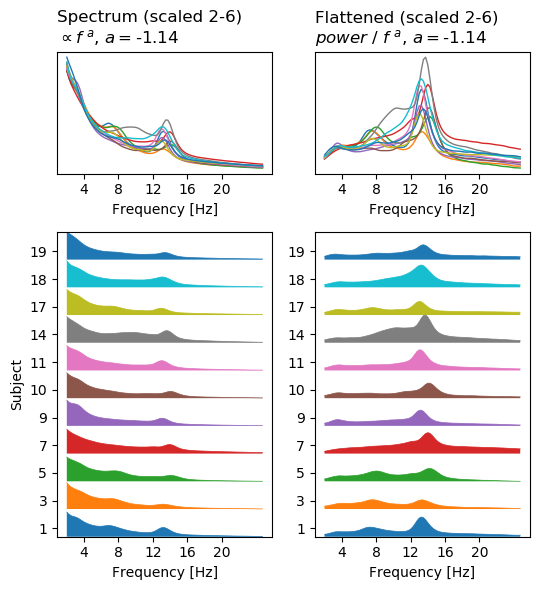

In [37]:
chosen_key = "spectrum_window"
first_freq = 2
last_freq = 25
fit_lowcut = 1
fit_highcut = 25
show_freqs = [4, 8, 12, 16, 20]
emphasize_subjects = None # [5, 19] # [14, 18]
show_power_law = False
scaled_id = "scaled %d-%d" % (band_scaling[0], band_scaling[1])
for train_analysis, analysis_id in zip([raw_train_analysis, scaled_train_analysis], ["raw", scaled_id]):
    # Find tendency
    coeffs = []
    for analysis in train_analysis:
        freq_full = analysis[chosen_key][:, 0]
        first_freq_loc = np.argmin((freq_full - fit_lowcut) ** 2)
        last_freq_loc = np.argmin((freq_full - fit_highcut) ** 2)
        freq = analysis[chosen_key][first_freq_loc:last_freq_loc, 0]
        power = analysis[chosen_key][first_freq_loc:last_freq_loc, 1]        
        fit_x = np.log(freq)
        fit_y = np.log(power)
        coeff = np.polyfit(fit_x, fit_y, 1)
        coeffs.append(coeff)
    coeffs = np.stack(coeffs, axis=0).mean(axis=0)
    def tendency(frequencies):
        result = np.exp(coeffs[1]) * (frequencies ** coeffs[0])
        return result
    def flatten(frequencies, power):
        result = power / (frequencies ** coeffs[0])
        return result

    # Plots
    fig = plt.figure(figsize=(5.5, 6), dpi=100)
    gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2.5])
    
    # True spectrum
    ax = fig.add_subplot(gs[0, 0])
    subjects_spectrum_raw = []
    for i, analysis in enumerate(train_analysis):
        freq_full = analysis[chosen_key][:, 0]
        first_freq_loc = np.argmin((freq_full - first_freq) ** 2)
        last_freq_loc = np.argmin((freq_full - last_freq) ** 2)
        freq = analysis[chosen_key][first_freq_loc:last_freq_loc, 0]
        power = analysis[chosen_key][first_freq_loc:last_freq_loc, 1]
        spectrum_raw = np.stack([freq, power], axis=1)
        subjects_spectrum_raw.append(spectrum_raw)
        if emphasize_subjects is None:
            ax.plot(freq, power, linewidth=1)
        else:
            if dataset.train_ids[i] in emphasize_subjects:
                ax.plot(freq, power, linewidth=1, color=viz.PALETTE['red'], zorder=30)
            else:
                ax.plot(freq, power, linewidth=1, color=viz.GREY_COLORS[5])
    if show_power_law:
        regr_freq = np.linspace(first_freq, last_freq)
        ax.plot(regr_freq, tendency(regr_freq), '--k', linewidth=1.5, label="Power Law")
        ax.legend(loc="upper right")
    ax.set_yticks([])
    ax.set_xticks(show_freqs)
    ax.set_xlabel("Frequency [Hz]")
    ax.set_title("Spectrum (%s)\n$\propto f^{\ a}$, $a=$%1.2f" % (analysis_id, coeffs[0]), loc="left")
    
    # True spectrum per subject
    ax = fig.add_subplot(gs[1, 0])
    subjects_spectrum_raw = np.stack(subjects_spectrum_raw, axis=0)
    min_val = subjects_spectrum_raw[:, :, 1].min()
    max_val = subjects_spectrum_raw[:, :, 1].max()
    for i, subject_spectrum in enumerate(subjects_spectrum_raw):
        spectrum = i + (subject_spectrum[:, 1] - min_val) / (max_val - min_val)
        freq_axis = subject_spectrum[:, 0]
        if emphasize_subjects is None:
            line = ax.plot(freq_axis, spectrum, linewidth=0.5)
        else:
            if dataset.train_ids[i] in emphasize_subjects:
                line = ax.plot(freq_axis, spectrum, linewidth=0.5, color=viz.PALETTE['red'], zorder=30)
            else:
                line = ax.plot(freq_axis, spectrum, linewidth=0.5, color=viz.GREY_COLORS[5])
        line_color = line[0].get_color()
        ax.fill_between(freq_axis, spectrum, i, facecolor=line_color, linewidth=0.5)
    ax.set_xticks(show_freqs)
    ax.set_xlabel("Frequency [Hz]")
    ytick_locs = np.arange(len(dataset.train_ids)) + 0.3
    ax.set_yticks(ytick_locs)
    ax.set_yticklabels(dataset.train_ids)
    ax.set_ylabel("Subject")
    ax.set_ylim([0, subjects_spectrum_raw.shape[0]])
    
    # Flat spectrum
    ax = fig.add_subplot(gs[0, 1])
    subjects_spectrum_flat = []
    for i, analysis in enumerate(train_analysis):
        freq_full = analysis[chosen_key][:, 0]
        first_freq_loc = np.argmin((freq_full - first_freq) ** 2)
        last_freq_loc = np.argmin((freq_full - last_freq) ** 2)
        freq = analysis[chosen_key][first_freq_loc:last_freq_loc, 0]
        power = analysis[chosen_key][first_freq_loc:last_freq_loc, 1]
        power = flatten(freq, power)
        spectrum_flat = np.stack([freq, power], axis=1)
        subjects_spectrum_flat.append(spectrum_flat)
        if emphasize_subjects is None:
            ax.plot(freq, power, linewidth=1)
        else:
            if dataset.train_ids[i] in emphasize_subjects:
                ax.plot(freq, power, linewidth=1, color=viz.PALETTE['red'], zorder=30)
            else:
                ax.plot(freq, power, linewidth=1, color=viz.GREY_COLORS[5])
    ax.set_yticks([])
    ax.set_xticks(show_freqs)
    ax.set_xlabel("Frequency [Hz]")
    ax.set_title("Flattened (%s) \n$power\ /\ f^{\ a}$, $a=$%1.2f" % (analysis_id, coeffs[0]), loc="left")
    
    # Flat spectrum per subject
    ax = fig.add_subplot(gs[1, 1])
    subjects_spectrum_flat = np.stack(subjects_spectrum_flat, axis=0)
    min_val = subjects_spectrum_flat[:, :, 1].min()
    max_val = subjects_spectrum_flat[:, :, 1].max()
    for i, subject_spectrum in enumerate(subjects_spectrum_flat):
        spectrum = i + (subject_spectrum[:, 1] - min_val) / (max_val - min_val)
        freq_axis = subject_spectrum[:, 0]
        if emphasize_subjects is None:
            line = ax.plot(freq_axis, spectrum, linewidth=0.5)
        else:
            if dataset.train_ids[i] in emphasize_subjects:
                line = ax.plot(freq_axis, spectrum, linewidth=0.5, color=viz.PALETTE['red'], zorder=30)
            else:
                line = ax.plot(freq_axis, spectrum, linewidth=0.5, color=viz.GREY_COLORS[5])
        line_color = line[0].get_color()
        ax.fill_between(freq_axis, spectrum, i, facecolor=line_color, linewidth=0.5)
    ax.set_xticks(show_freqs)
    ax.set_xlabel("Frequency [Hz]")
    ytick_locs = np.arange(len(dataset.train_ids)) + 0.3
    ax.set_yticks(ytick_locs)
    ax.set_yticklabels(dataset.train_ids)
    # ax.set_ylabel("Subject")
    ax.set_ylim([0, subjects_spectrum_flat.shape[0]])
    
    plt.tight_layout()
    plt.show()

# Spindle spectral parameters
Like power ratios and spectrum of 2s centered on spindle

In [38]:
train_analysis = []
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    stamps = dataset.get_subject_stamps(subject_id, which_expert=1, pages_subset=constants.N2_RECORD)
    stamps_center = stamps.mean(axis=1)
    stamps[:, 0] = stamps_center - fs
    stamps[:, 1] = stamps_center + fs
    signal_on_spindles = [signal[s_start:s_end] for (s_start, s_end) in stamps]
    analysis = []
    for signal_window in signal_on_spindles:
        analysis_results = analyze_spindle_window(signal_window, fs)
        analysis.append(analysis_results)
    analysis = listify_dictionaries(analysis)
    train_analysis.append(analysis)

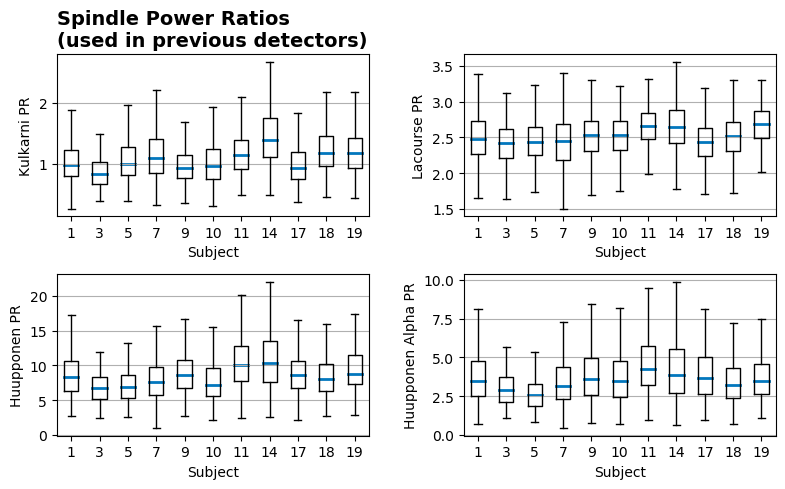

In [39]:
common_args = {
    "labels": dataset.train_ids, "showfliers": False, "flierprops": {'markersize': 2}, 
    "medianprops": dict(linewidth=2, color=viz.PALETTE['blue'], zorder=1)
}

fig, axes = plt.subplots(2, 2, figsize=(8, 5), dpi=100)
axes[0, 0].set_title("Spindle Power Ratios \n(used in previous detectors)", fontweight='bold', loc="left", fontsize=14)
ax = axes[0, 0]
ax.set_ylabel("Kulkarni PR")
ax.boxplot([analysis['pr_spindlenet'] for analysis in train_analysis], **common_args)
ax = axes[0, 1]
ax.set_ylabel("Lacourse PR")
ax.boxplot([analysis['pr_a7'] for analysis in train_analysis], **common_args)
ax = axes[1, 0]
ax.set_ylabel("Huupponen PR")
ax.boxplot([analysis['pr_huupp'] for analysis in train_analysis], **common_args)
ax = axes[1, 1]
ax.set_ylabel("Huupponen Alpha PR")
ax.boxplot([analysis['pr_huupp_alfa'] for analysis in train_analysis], **common_args)
for ax in axes.flatten():
    ax.grid(axis='y')
    ax.set_xlabel("Subject")
plt.tight_layout()
plt.show()

In [40]:
train_analysis = []
bands_list = [
    [0.5, 2],
    [2, 4],
    [4, 6],
    [6, 8],
    [8, 10],
    [10, 12],
    [12, 14],
    [14, 16],
    [16, 18],
    [18, 20]
]
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    stamps = dataset.get_subject_stamps(subject_id, which_expert=1, pages_subset=constants.N2_RECORD)
    stamps_center = stamps.mean(axis=1)
    stamps[:, 0] = stamps_center - fs
    stamps[:, 1] = stamps_center + fs
    signal_on_spindles = [signal[s_start:s_end] for (s_start, s_end) in stamps]
    analysis = []
    for signal_window in signal_on_spindles:
        analysis_results = analyze_spindle_window_custom(signal_window, fs, bands_list)
        analysis.append(analysis_results)
    analysis = listify_dictionaries(analysis)
    train_analysis.append(analysis)

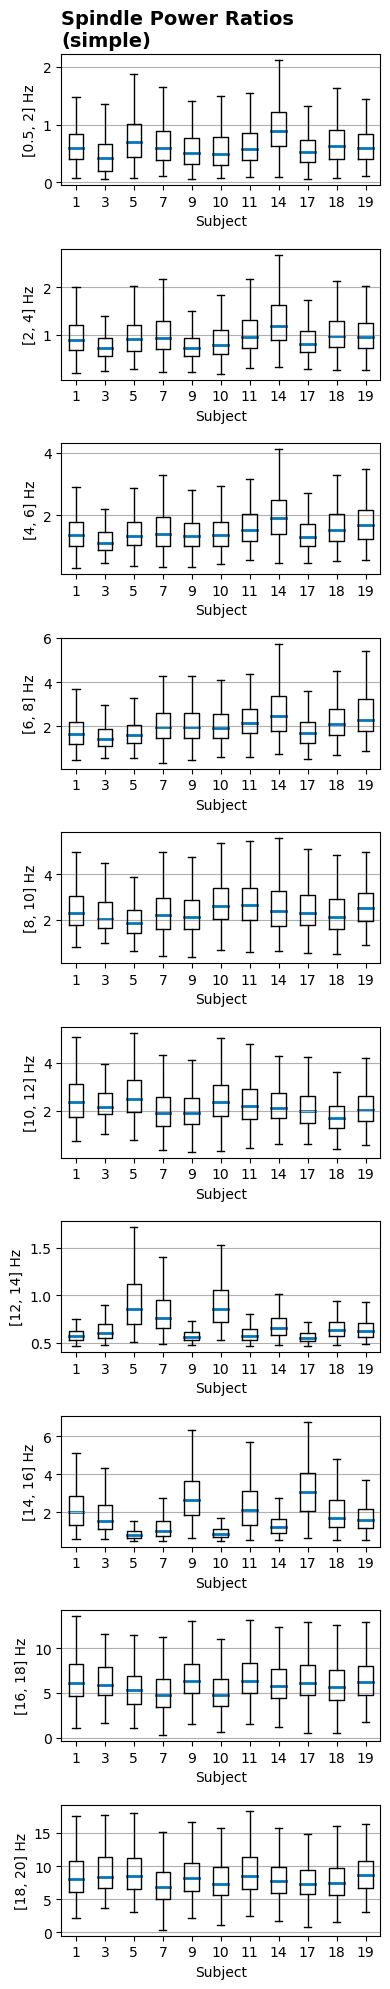

In [41]:
common_args = {
    "labels": dataset.train_ids, "showfliers": False, "flierprops": {'markersize': 2}, 
    "medianprops": dict(linewidth=2, color=viz.PALETTE['blue'], zorder=1)
}
n_bands = len(bands_list)

fig, axes = plt.subplots(n_bands, 1, figsize=(4, 2 * n_bands), dpi=100)
axes[0].set_title("Spindle Power Ratios\n(simple)", fontweight='bold', loc="left", fontsize=14)
for j in range(n_bands):
    axes[j].set_ylabel("%s Hz" % bands_list[j])
    axes[j].boxplot([analysis['band_%d' % j] for analysis in train_analysis], **common_args)
for ax in axes.flatten():
    ax.grid(axis='y')
    ax.set_xlabel("Subject")
plt.tight_layout()
plt.show()

In [45]:
window_size = 2
train_analysis = []
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    stamps = dataset.get_subject_stamps(subject_id, which_expert=1, pages_subset=constants.N2_RECORD)
    stamps_center = stamps.mean(axis=1)
    stamps[:, 0] = (stamps_center - window_size * fs / 2).astype(np.int32)
    stamps[:, 1] = stamps[:, 0] + window_size * fs
    signal_on_spindles = [signal[s_start:s_end] for (s_start, s_end) in stamps]
    analysis = []
    for signal_window in signal_on_spindles:
        analysis_results = analyze_spindle_window_spectrum(signal_window, fs)
        analysis.append(analysis_results)
    analysis = listify_dictionaries(analysis)
    train_analysis.append(analysis)

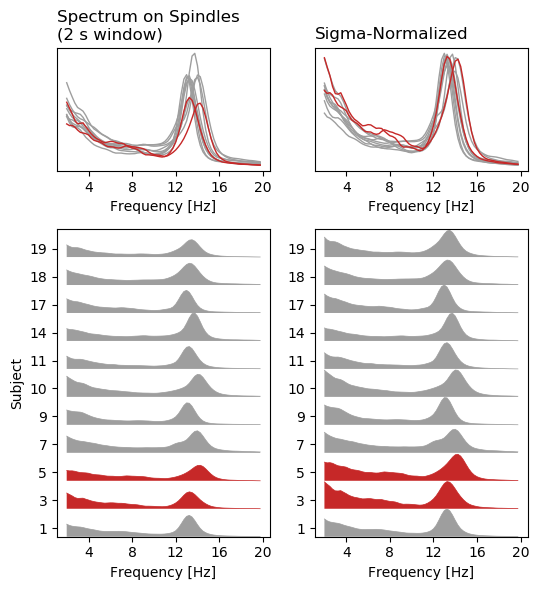

In [47]:
first_freq = 2
last_freq = 20
fit_lowcut = 1
fit_highcut = 25
show_freqs = [4, 8, 12, 16, 20]
emphasize_subjects = [3, 5] # [1, 5, 9, 18] # [11, 14, 19] # None # [5, 19] # [14, 18]

# Plots
fig = plt.figure(figsize=(5.5, 6), dpi=100)
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 2.5])

# True spectrum
ax = fig.add_subplot(gs[0, 0])
subjects_spectrum_raw = []
for i, analysis in enumerate(train_analysis):
    freq_full = analysis["spectrum"][0][:, 0]
    first_freq_loc = np.argmin((freq_full - first_freq) ** 2)
    last_freq_loc = np.argmin((freq_full - last_freq) ** 2)
    freq = analysis["spectrum"][0][first_freq_loc:last_freq_loc, 0]
    powers = [spec[first_freq_loc:last_freq_loc, 1] for spec in analysis["spectrum"]]
    powers = np.stack(powers, axis=0)
    mean_power = powers.mean(axis=0)
    spectrum_raw = np.stack([freq, mean_power], axis=1)
    subjects_spectrum_raw.append(spectrum_raw)
    if emphasize_subjects is None:
        ax.plot(freq, mean_power, linewidth=1)
    else:
        if dataset.train_ids[i] in emphasize_subjects:
            ax.plot(freq, mean_power, linewidth=1, color=viz.PALETTE['red'], zorder=30)
        else:
            ax.plot(freq, mean_power, linewidth=1, color=viz.GREY_COLORS[5])
ax.set_yticks([])
ax.set_xticks(show_freqs)
ax.set_xlabel("Frequency [Hz]")
ax.set_title("Spectrum on Spindles\n(%d s window)" % window_size, loc="left")

# True spectrum per subject
ax = fig.add_subplot(gs[1, 0])
subjects_spectrum_raw = np.stack(subjects_spectrum_raw, axis=0)
min_val = subjects_spectrum_raw[:, :, 1].min()
max_val = subjects_spectrum_raw[:, :, 1].max()
for i, subject_spectrum in enumerate(subjects_spectrum_raw):
    spectrum = i + (subject_spectrum[:, 1] - min_val) / (max_val - min_val)
    freq_axis = subject_spectrum[:, 0]
    if emphasize_subjects is None:
        line = ax.plot(freq_axis, spectrum, linewidth=0.5)
    else:
        if dataset.train_ids[i] in emphasize_subjects:
            line = ax.plot(freq_axis, spectrum, linewidth=0.5, color=viz.PALETTE['red'], zorder=30)
        else:
            line = ax.plot(freq_axis, spectrum, linewidth=0.5, color=viz.GREY_COLORS[5])
    line_color = line[0].get_color()
    ax.fill_between(freq_axis, spectrum, i, facecolor=line_color, linewidth=0.5)
ax.set_xticks(show_freqs)
ax.set_xlabel("Frequency [Hz]")
ytick_locs = np.arange(len(dataset.train_ids)) + 0.3
ax.set_yticks(ytick_locs)
ax.set_yticklabels(dataset.train_ids)
ax.set_ylim([0, subjects_spectrum_raw.shape[0]])
ax.set_ylabel("Subject")

# spectrum divided by sigma power
ax = fig.add_subplot(gs[0, 1])
subjects_spectrum_flat = []
for i, analysis in enumerate(train_analysis):
    freq_full = analysis["spectrum_sigma_norm"][0][:, 0]
    first_freq_loc = np.argmin((freq_full - first_freq) ** 2)
    last_freq_loc = np.argmin((freq_full - last_freq) ** 2)
    freq = analysis["spectrum_sigma_norm"][0][first_freq_loc:last_freq_loc, 0]
    powers = [spec[first_freq_loc:last_freq_loc, 1] for spec in analysis["spectrum_sigma_norm"]]
    powers = np.stack(powers, axis=0)
    mean_power = powers.mean(axis=0)
    spectrum_flat = np.stack([freq, mean_power], axis=1)
    subjects_spectrum_flat.append(spectrum_flat)
    if emphasize_subjects is None:
        ax.plot(freq, mean_power, linewidth=1)
    else:
        if dataset.train_ids[i] in emphasize_subjects:
            ax.plot(freq, mean_power, linewidth=1, color=viz.PALETTE['red'], zorder=30)
        else:
            ax.plot(freq, mean_power, linewidth=1, color=viz.GREY_COLORS[5])
ax.set_yticks([])
ax.set_xticks(show_freqs)
ax.set_xlabel("Frequency [Hz]")
ax.set_title("Sigma-Normalized", loc="left")

# Flat spectrum per subject
ax = fig.add_subplot(gs[1, 1])
subjects_spectrum_flat = np.stack(subjects_spectrum_flat, axis=0)
min_val = subjects_spectrum_flat[:, :, 1].min()
max_val = subjects_spectrum_flat[:, :, 1].max()
for i, subject_spectrum in enumerate(subjects_spectrum_flat):
    spectrum = i + (subject_spectrum[:, 1] - min_val) / (max_val - min_val)
    freq_axis = subject_spectrum[:, 0]
    if emphasize_subjects is None:
        line = ax.plot(freq_axis, spectrum, linewidth=0.5)
    else:
        if dataset.train_ids[i] in emphasize_subjects:
            line = ax.plot(freq_axis, spectrum, linewidth=0.5, color=viz.PALETTE['red'], zorder=30)
        else:
            line = ax.plot(freq_axis, spectrum, linewidth=0.5, color=viz.GREY_COLORS[5])
    line_color = line[0].get_color()
    ax.fill_between(freq_axis, spectrum, i, facecolor=line_color, linewidth=0.5)
ax.set_xticks(show_freqs)
ax.set_xlabel("Frequency [Hz]")
ytick_locs = np.arange(len(dataset.train_ids)) + 0.3
ax.set_yticks(ytick_locs)
ax.set_yticklabels(dataset.train_ids)
ax.set_ylim([0, subjects_spectrum_flat.shape[0]])
# ax.set_ylabel("Subject")

plt.tight_layout()
plt.show()

# Error Analysis

In [ ]:
# Settings
ref_ckpt_folder = '20200724_reproduce_red_n2_train_mass_ss/v19_rep1'
seed_id_list = [0, 1, 2, 3]

which_expert = 1
task_mode = constants.N2_RECORD
set_list = [constants.VAL_SUBSET, constants.TRAIN_SUBSET]
iou_thr = 0.2
iou_hist_bins = np.linspace(0, 1, 21)
iou_curve_axis = misc.custom_linspace(0.05, 0.95, 0.05)
ids_dict = {constants.ALL_TRAIN_SUBSET: dataset.train_ids, constants.TEST_SUBSET: dataset.test_ids}
ids_dict.update(misc.get_splits_dict(dataset, seed_id_list))

# Load predictions
ref_predictions_dict = reader.read_prediction_with_seeds(
    ref_ckpt_folder, dataset_name, task_mode, seed_id_list, set_list=set_list, parent_dataset=dataset)

## Adjust model probabilities
Probabilities are adjusted so that the threshold is always 0.5 for all seeds.

## Subjects 11, 14 and 19 (low precision)

### Adjusted probability analysis
True Spindles are simply the expert annotations.
False Spindles are found as detections with adjusted probability greater than 0.2 not intersecting with True Spindles.